In [1]:
% matplotlib inline
import torch
from d2l import torch as d2l

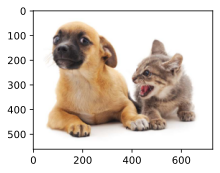

In [2]:
d2l.set_figsize()
img = d2l.plt.imread('02_Data/catdog.jpg')
d2l.plt.imshow(img)

In [3]:
# 定义在这两种表示之间进行转换的函数
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes


def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [4]:
# 定义图像中狗和猫的边界框
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]
boxes = torch.tensor((dog_bbox, cat_bbox))
# boxes 转中间表示，再转回来，等于自己
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

In [5]:
# 将边界框在图中画出
def bbox_to_rect(bbox, color):
    return d2l.plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0],
                             height=bbox[3] - bbox[1], fill=False,
                             edgecolor=color, linewidth=2)

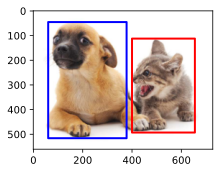

In [6]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'))

In [7]:
% matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

In [8]:
d2l.DATA_HUB['banana-detection'] = (d2l.DATA_URL + 'banana-detection.zip', '5de25c8fce5ccdea9f91267273465dc968d20d72')

In [9]:
# 读取香蕉检测数据集
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir,
                             'bananas_train' if is_train else 'bananas_val',
                             'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    # 把图片、标号全部读到内存里面
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'images', f'{img_name}')))
        targets.append(list(target))
    print("len(targets)：", len(targets))
    print("len(targets[0])：", len(targets[0]))
    print("targets[0][0]....targets[0][4]：", targets[0][0], targets[0][1], targets[0][2], targets[0][3], targets[0][4])
    print("type(targets)：", type(targets))
    print("torch.tensor(targets).unsqueeze(1).shape：",
          torch.tensor(targets).unsqueeze(1).shape)  # unsqueeze函数在指定位置加上维数为一的维度
    print("len(torch.tensor(targets).unsqueeze(1) / 256)：", len(torch.tensor(targets).unsqueeze(1) / 256))
    print("type(torch.tensor(targets).unsqueeze(1) / 256)：", type(torch.tensor(targets).unsqueeze(1) / 256))
    return images, torch.tensor(targets).unsqueeze(1) / 256  # 归一化使得收敛更快

In [10]:
# 创建一个自定义Dataset实例
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""

    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if is_train else f'validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [11]:
# 为训练集和测试集返回两个数据加载器实例
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

In [14]:
# 读取一个小批量，并打印其中的图像和标签的形状
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
# ([32,1,5]) 中的1是每张图片中有几种类别，这里只有一种香蕉要识别的类别
# 5是类别标号、框的四个参数
batch[0].shape, batch[1].shape

len(targets)： 1000
len(targets[0])： 5
targets[0][0]....targets[0][4]： 0 104 20 143 58
type(targets)： <class 'list'>
torch.tensor(targets).unsqueeze(1).shape： torch.Size([1000, 1, 5])
len(torch.tensor(targets).unsqueeze(1) / 256)： 1000
type(torch.tensor(targets).unsqueeze(1) / 256)： <class 'torch.Tensor'>
read 1000 training examples
len(targets)： 100
len(targets[0])： 5
targets[0][0]....targets[0][4]： 0 183 63 241 112
type(targets)： <class 'list'>
torch.tensor(targets).unsqueeze(1).shape： torch.Size([100, 1, 5])
len(torch.tensor(targets).unsqueeze(1) / 256)： 100
type(torch.tensor(targets).unsqueeze(1) / 256)： <class 'torch.Tensor'>
read 100validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

原始图片:
 tensor([[[  1.,   8.,  20.,  ...,   7.,   6.,   3.],
         [  9.,  22.,   9.,  ...,   2.,   0.,  12.],
         [ 17.,  11.,  12.,  ...,   0.,   0.,   4.],
         ...,
         [ 26.,   6.,  10.,  ...,  67.,  70.,  62.],
         [  7.,  13.,   8.,  ...,  47.,  62.,  85.],
         [  8.,   8.,  16.,  ..., 128., 116., 130.]],

        [[ 68.,  78.,  93.,  ...,  50.,  47.,  44.],
         [ 81.,  94.,  86.,  ...,  44.,  42.,  54.],
         [ 94.,  90.,  94.,  ...,  40.,  44.,  48.],
         ...,
         [ 42.,  22.,  28.,  ..., 114., 115., 107.],
         [ 18.,  24.,  19.,  ...,  91., 106., 129.],
         [ 17.,  17.,  25.,  ..., 172., 158., 172.]],

        [[ 84.,  90., 102.,  ...,  43.,  43.,  40.],
         [ 96., 109.,  96.,  ...,  40.,  40.,  52.],
         [114., 107., 108.,  ...,  39.,  45.,  49.],
         ...,
         [ 31.,  11.,  16.,  ...,  12.,  20.,  14.],
         [ 10.,  16.,  11.,  ...,   0.,   8.,  31.],
         [ 12.,  12.,  20.,  ...,  77.,  60., 

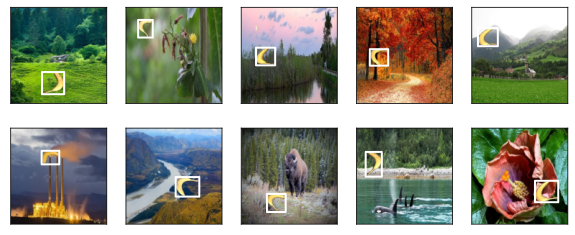

In [15]:
# 示例
# pytorch里permute是改变参数维度的函数，
# Dataset里读的img维度是[batch_size, RGB, h, w]，
# 但是plt画图的时候要求是[h, w, RGB]，所以要调整一下

# 做图片的时候，一般是会用一个ToTensor()将图片归一化到【0, 1】，这样收敛更快
print("原始图片:\n", batch[0][0])
print("原始图片:\n", (batch[0][0:10].permute(0, 2, 3, 1)))
print("归一化后图片:\n", (batch[0][0:10].permute(0, 2, 3, 1)) / 255)
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
#imgs = (batch[0][0:10].permute(0,2,3,1))
# d2l.show_images输入的imgs图片参数是归一化后的图片
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])